In [4]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from ase.io import read
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pymatgen.io.cif")
warnings.filterwarnings("ignore", category=UserWarning, module="ase.io.cif")
import multiprocessing as mp
from functools import partial

## Download CoREMOF2019 database

In [ ]:
## download and extract CoREMOF 2019 dataset from MOFXDB(https://mof.tech.northwestern.edu/databases)
!wget https://mof.tech.northwestern.edu/Datasets/CoREMOF%202019-mofdb-version:dc8a0295db.zip -O ./raw_data/CoREMOF_2019-mofdb-version:dc8a0295db.zip
!unzip -o ./raw_data/CoREMOF_2019-mofdb-versiondc8a0295db.zip -d ./raw_data/CoREMOF2019


1 file had no zipfile directory.
No zipfiles found.


## TSD&SSD processing

In [5]:
ssd_csv = "./raw_data/SciData/separate_files/solvent_removal_stability/full_SSD_data.csv"
tsd_csv = "./raw_data/SciData/separate_files/thermal_stability/full_TSD_data.csv"
saved_dir = Path("./CGCNN_MT/data/")
src_cif_dir = Path("./raw_data/CoREMOF2019")

In [3]:
df_ssd = pd.read_csv(ssd_csv)
df_tsd = pd.read_csv(tsd_csv)
df_ssd.dropna(inplace=True)
df_tsd.dropna(inplace=True)
print(df_ssd.shape)
print(df_tsd.shape)
print(df_ssd.columns)
print(df_tsd.columns)
df_ssd.head()

(2179, 189)
(3132, 189)
Index(['CoRE_name', 'refcode', 'doi', 'assigned_solvent_removal_stability',
       'ANN_predicted_solvent_removal_stability', 'ANN_prediction_probability',
       'ANN_LSE', 'partition', 'Df (Å)', 'Di (Å)',
       ...
       'D_func-S-1-all', 'D_func-S-2-all', 'D_func-S-3-all',
       'explicit_intro_in_paper', 'number_of_sentences_in_paper',
       'sentence_indices', 'collapse_keywords', 'solvent_keywords',
       'stability_keywords', 'sentences'],
      dtype='object', length=189)
Index(['CoRE_name', 'refcode', 'doi', 'assigned_T_decomp (°C)',
       'ANN_predicted_T_decomp (°C)', 'ANN_LSD_10NN', 'ANN_LSD_10NN_scaled',
       'partition', 'Df (Å)', 'Di (Å)',
       ...
       'D_func-S-1-all', 'D_func-S-2-all', 'D_func-S-3-all', 'TGA_points_T',
       'TGA_points_mass', 'explicit_intro_in_paper',
       'number_of_sentences_in_paper', 'sentence_indices', 'keywords',
       'sentences'],
      dtype='object', length=189)


,CoRE_name,refcode,doi,assigned_solvent_removal_stability,ANN_predicted_solvent_removal_stability,ANN_prediction_probability,ANN_LSE,partition,Df (Å),Di (Å),...,D_func-S-1-all,D_func-S-2-all,D_func-S-3-all,explicit_intro_in_paper,number_of_sentences_in_paper,sentence_indices,collapse_keywords,solvent_keywords,stability_keywords,sentences
0,ABAVIJ_clean,ABAVIJ,10.1039/b404485a,1.0,1.0,0.943282,0.001705,train,2.49720,4.45543,...,0.000000,0.000000,0.00,True,176.0,"[60, 66]","[None, None]","[['desolv'], ['solvate', 'desolv', 'lose']]","[['retain'], ['retain']]",['Single crystals of 1 appeared to retain thei...
1,ABAYIO_clean,ABAYIO,10.1021/acs.cgd.6b00776,1.0,1.0,0.920237,0.001713,train,4.31822,11.38838,...,0.000000,0.000000,0.00,True,359.0,"[142, 143]","[None, None]","[['remov', 'water'], ['activat']]","[['porosity'], [' stable']]",['The porosity of 1 calculated by PLATON(31) i...
2,ABESUX_clean,ABESUX,10.1021/ic200345j,1.0,1.0,0.926693,0.001737,train,4.42071,5.87733,...,0.000000,0.000000,0.00,True,379.0,"[159, 167, 268, 156]","[None, None, None, None]","[['diamine'], ['diamine'], ['diamine'], ['H2O'...","[[' stable'], ['stability'], [' stable'], [' s...",['(24-28) It is noteworthy that in our neutral...
3,ABETAE_clean,ABETAE,10.1021/ic200345j,1.0,1.0,0.926645,0.001737,train,4.42278,5.88004,...,0.000000,0.000000,0.00,True,379.0,"[159, 167, 268, 156]","[None, None, None, None]","[['diamine'], ['diamine'], ['diamine'], ['H2O'...","[[' stable'], ['stability'], [' stable'], [' s...",['(24-28) It is noteworthy that in our neutral...
4,ABEXEM_clean,ABEXEM,10.1021/ic201013v,0.0,0.0,0.089531,0.001667,train,4.14331,4.82084,...,-0.013333,-0.013333,-0.02,True,646.0,"[128, 191]","[['collaps'], ['amorph']]","[['remov'], ['water']]","[None, [' stable', 'crystallinity']]",['The single crystals of 2-Ln suffer a progres...


In [4]:
select_cols1 = ["CoRE_name", "assigned_solvent_removal_stability", "partition"]
select_cols2 = ["CoRE_name", "assigned_T_decomp (°C)", "partition"]
feat_cols = df_ssd.loc[:, "Df (Å)":"D_func-S-3-all"].columns.tolist()
std_cols = ["MofName", "Label", "Partition"] + feat_cols
df_ssd = df_ssd[select_cols1 + feat_cols]
df_ssd.columns = std_cols
df_tsd = df_tsd[select_cols2 + feat_cols]
df_tsd.columns = std_cols

In [5]:
df_tsd["Partition"].unique()

array(['train', 'val', 'test'], dtype=object)

In [6]:
all_cifs = src_cif_dir.glob('*.cif')
all_cif_names = [cif.stem for cif in all_cifs]

print(len(all_cif_names))

print(len(df_ssd))
print(len(df_tsd))

print(df_ssd['MofName'].isin(all_cif_names).sum())
print(df_tsd['MofName'].isin(all_cif_names).sum())


12020
2179
3132
2179
3132


In [ ]:
def get_atom_num(cif_file):
    atoms = read(cif_file)
    return len(atoms)

for df, task in zip([df_ssd, df_tsd], ["SSD", "TSD"]):
    task_dir =saved_dir/task
    cif_dir = task_dir/"cifs"
    # cif_dir.mkdir(exist_ok=True, parents=True)
    df.to_csv(task_dir/"id_prop_feat.csv", index=False)
    for i, row in df.iterrows():
        cif_file = str(cif_dir/f"{row['MofName']}.cif")
        src_cif_file = str(src_cif_dir/f"{row['MofName']}.cif")
        # shutil.copyfile(src_cif_file, cif_file)
        ## clean cif file
        # overlap_removal(src_cif_file, cif_file) # Input CIF should have P1 symmetry.
        # solvent_removal(cif_file, cif_file)
        if i%500==0:
            print(f"{i}/{len(df)}")
    
    with mp.Pool(processes=6) as pool:
        atom_num_list = pool.map(get_atom_num, cif_dir.glob("*.cif"))

    plt.hist(atom_num_list, bins=100)
    plt.xlabel('Number of atoms')
    plt.ylabel('Frequency')
    plt.title(f"Histogram of number of atoms in {task} dataset")
    plt.show()

0/2179 (0.0% completed)
500/2179 (22.9% completed)
1000/2179 (45.9% completed)
1500/2179 (68.8% completed)
2000/2179 (91.8% completed)
Starting atom counting for SSD dataset...
Found 2179 CIF files to process


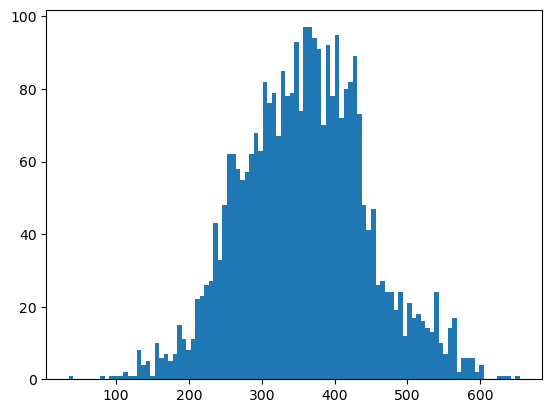

In [19]:
plt.hist(df_tsd['Label'], bins=100)
plt.show()

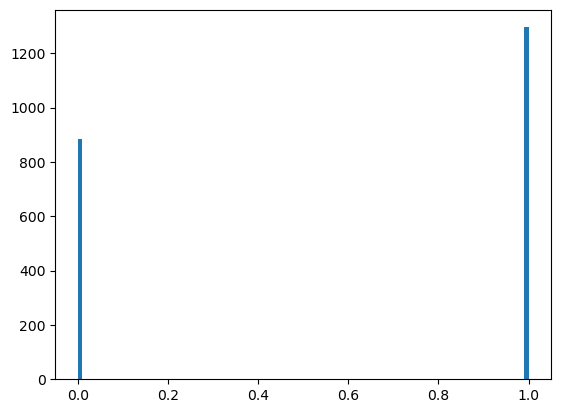

In [20]:
plt.hist(df_ssd['Label'], bins=100)
plt.show()

### Reneragete zeo++ and RACs features for TSD and SSS datasets.

In [13]:
from CGCNN_MT.datamodule import clean_cif
import subprocess
import threading
import time

## clean cifs
for task in  ["SSD", "TSD"]:
    task_dir =saved_dir/task
    cif_dir = task_dir/"cifs"
    output_dir = task_dir/"clean_cifs"
    clean_cif.main(cif_dir, output_dir, log_file=task_dir/"clean_cif.log", santize=True, n_cpus=1)

## generate features
for task in  ["SSD", "TSD"]:
    task_dir =saved_dir/task
    clean_cif_dir = task_dir/"clean_cifs"
    output_dir = task_dir/"features"
    work_dir = Path("./ML/featuring")
    
    def monitor_progress():
        start_time = time.time()
        while process.poll() is None:
            elapsed = time.time() - start_time
            print(f"Process running for {elapsed:.1f}s - Task: {task}")
            time.sleep(10)
    
    process = subprocess.Popen(
        f"python {work_dir/'feature_generation.py'} --cif_dir {clean_cif_dir} --prob_radius 1.86",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        shell=True,
        env=os.environ.copy(),
        cwd=str(work_dir)
    )
    
    # Start monitoring thread
    monitor_thread = threading.Thread(target=monitor_progress)
    monitor_thread.daemon = True
    monitor_thread.start()
    
    # Wait for process to complete
    stdout, stderr = process.communicate()
    
    print(f"Task {task} completed")
    if process.returncode != 0:
        print(f"Error in {task}: {stderr.decode()}")
    else:
        print(f"Success in {task}")

Number of CIFs to clean: 2179
Number of CIFs to clean: 3132
Process running for 0.0s - Task: SSD
Task SSD completed
Error in SSD: python: can't open file 'c:\Dharun\SEM7\Final_Year\MOFSNN_D\ML\featuring\ML\featuring\feature_generation.py': [Errno 2] No such file or directory

Process running for 0.0s - Task: TSD
Task TSD completed
Error in TSD: python: can't open file 'c:\Dharun\SEM7\Final_Year\MOFSNN_D\ML\featuring\ML\featuring\feature_generation.py': [Errno 2] No such file or directory



In [5]:
import subprocess
import time
import os
from pathlib import Path
import random
import shutil

saved_dir = Path("./CGCNN_MT/data/")
work_dir = Path("./ML/featuring")

# 1. Test run on a single random CIF file
print("--- Starting Test Run ---")
task = "SSD" # Pick one task for testing
task_dir = saved_dir / task
clean_cif_dir = task_dir / "clean_cifs"
all_cifs = list(clean_cif_dir.glob("*.cif"))

if all_cifs:
    random_cif = random.choice(all_cifs)
    print(f"Testing on single file: {random_cif.name}")
    
    # Create a temporary directory for the single file test to avoid processing everything
    temp_test_dir = task_dir / "temp_test_cif"
    if temp_test_dir.exists():
        shutil.rmtree(temp_test_dir)
    temp_test_dir.mkdir(exist_ok=True)
    
    # Symlink or copy the random cif to temp dir
    temp_cif_path = temp_test_dir / random_cif.name
    if not temp_cif_path.exists():
        # Using symlink if possible, else copy (os.symlink might require admin on windows)
        try:
            os.symlink(random_cif.resolve(), temp_cif_path)
        except OSError:
            shutil.copy(random_cif, temp_cif_path)
            
    abs_test_dir = temp_test_dir.resolve()
    
    process = subprocess.Popen(
        f"python feature_generation.py --cif_dir {abs_test_dir} --prob_radius 1.86",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        shell=True,
        env=os.environ.copy(),
        cwd=str(work_dir)
    )
    
    stdout, stderr = process.communicate()
    
    # Cleanup temp dir
    if temp_cif_path.exists():
        os.remove(temp_cif_path)
    temp_test_dir.rmdir()

    if process.returncode == 0:
        print("Test run SUCCESS")
        print(f"Output snippet: {stdout.decode()[:500]}")
    else:
        print("Test run FAILED")
        print(f"Error: {stderr.decode()}")
        raise RuntimeError("Test run failed. Stopping execution.")

else:
    print("No CIF files found for testing.")
    raise RuntimeError("No CIF files found.")

# 2. Full Run
print("\n--- Starting Full Run ---")
for task in ["SSD", "TSD"]:
    task_dir = saved_dir / task
    clean_cif_dir = task_dir / "clean_cifs"
    
    num_cifs = len(list(clean_cif_dir.glob("*.cif")))
    print(f"Task {task}: Processing {num_cifs} CIF files")
    
    abs_clean_cif_dir = clean_cif_dir.resolve()
    
    start_time = time.time()
    
    process = subprocess.Popen(
        f"python feature_generation.py --cif_dir {abs_clean_cif_dir} --prob_radius 1.86",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        shell=True,
        env=os.environ.copy(),
        cwd=str(work_dir)
    )
    
    stdout, stderr = process.communicate()
    elapsed = time.time() - start_time
    
    print(f"Task {task} completed in {elapsed/60:.1f} minutes")
    
    if process.returncode != 0:
        print(f"Process failed with return code {process.returncode}")
        print(f"Errors: {stderr.decode()}")
    else:
        print(f"Success. Output snippet: {stdout.decode()[-500:]}") # Print last 500 chars

--- Starting Test Run ---
Testing on single file: MOYNIY_clean.cif
Test run SUCCESS
Output snippet: Generating features for all MOFs using 96 cores.
The current MOF is MOYNIY_clean. Number 1 of 1.
unsuccessful_featurizations is []


--- Starting Full Run ---
Task SSD: Processing 2179 CIF files
Test run SUCCESS
Output snippet: Generating features for all MOFs using 96 cores.
The current MOF is MOYNIY_clean. Number 1 of 1.
unsuccessful_featurizations is []


--- Starting Full Run ---
Task SSD: Processing 2179 CIF files
Task SSD completed in 127.3 minutes
Success. Output snippet: clean', 'XUJQAV_clean', 'XULCIR_clean', 'XUYXAR_clean', 'YARSAN_clean', 'YATDUV_clean', 'YAVWUQ_clean', 'YEGTEK_clean', 'YEKXET_clean', 'YOCDUR_clean', 'YOYBUL_clean', 'YOYTOX_clean', 'YOYTUD_clean', 'YOYVAL_clean', 'YOYVEP01_clean', 'YOYVOZ01_clean', 'YOYVOZ_clean', 'YOYWEQ01_clean', 'YOYWEQ_clean', 'YOZJEE01_clean', 'YOZJEE_clean', 'YOZKOP_clean', 'ZAGHAT_clean', 'ZEHCAQ01_clean', 'ZIJVAR_clean', 'ZIJVOF01_clea

In [2]:
## merge with id_prop_feat.csv
df_ssd_new = pd.read_csv('./CGCNN_MT/data/SSD/RAC_and_zeo_features.csv')
df_tsd_new = pd.read_csv('./CGCNN_MT/data/TSD/RAC_and_zeo_features.csv')

print(df_ssd_new.shape)
print(df_tsd_new.shape)

df_ssd = pd.read_csv('./CGCNN_MT/data/SSD/id_prop_feat.csv')
df_tsd = pd.read_csv('./CGCNN_MT/data/TSD/id_prop_feat.csv')

print(df_ssd.shape)
print(df_tsd.shape)

df_ssd_new.drop(columns=['cif_file'], inplace=True)
df_tsd_new.drop(columns=['cif_file'], inplace=True)
df_ssd_new.rename(columns={'name': 'MofName'}, inplace=True)
df_tsd_new.rename(columns={'name': 'MofName'}, inplace=True)

df_ssd_new = df_ssd[["MofName", "Label", "Partition"]].merge(df_ssd_new, on="MofName", how="right")
df_tsd_new = df_tsd[["MofName", "Label", "Partition"]].merge(df_tsd_new, on="MofName", how="right")

df_ssd_new.to_csv('./CGCNN_MT/data/SSD/RAC_and_zeo_features_with_id_prop.csv', index=False)
df_tsd_new.to_csv('./CGCNN_MT/data/TSD/RAC_and_zeo_features_with_id_prop.csv', index=False)

print(df_ssd_new.shape)
print(df_tsd_new.shape)

(1608, 192)
(2423, 192)
(2179, 177)
(3132, 177)
(1608, 193)
(2423, 193)


## prepare graph data

In [1]:
from CGCNN_MT.datamodule.prepare_data import make_prepared_data
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pymatgen.io.cif")

In [6]:
import random

saved_dir = Path("./CGCNN_MT/data/")
work_dir = Path("./ML/featuring")

# Test run on 2 random CIF files first
print("--- Starting Test Run on 2 Random CIF Files ---")

for task in ["SSD", "TSD"]:
    task_dir = saved_dir / task
    clean_cif_dir = task_dir / "clean_cifs"
    all_cifs = list(clean_cif_dir.glob("*.cif"))
    
    if len(all_cifs) < 2:
        print(f"Not enough CIF files in {task} for testing")
        continue
        
    # Select 2 random files for testing
    test_files = random.sample(all_cifs, 2)
    print(f"\nTesting {task} with files: {[f.name for f in test_files]}")
    
    success_count = 0
    for cif_file in test_files:
        try:
            flag = make_prepared_data(cif_file, clean_cif_dir, radius=8, max_num_nbr=10)
            if flag:
                print(f"  ✓ Success: {cif_file.name}")
                success_count += 1
            else:
                print(f"  ✗ Failed: {cif_file.name}")
        except Exception as e:
            print(f"  ✗ Error with {cif_file.name}: {str(e)}")
    
    print(f"Test results for {task}: {success_count}/2 successful")
    
    if success_count == 0:
        print(f"All test files failed for {task}. Stopping full processing.")
        break

# If test was successful, run full processing
print("\n--- Starting Full Processing ---")
for task in ["SSD", "TSD"]:
    task_dir = saved_dir / task
    clean_cif_dir = task_dir / "clean_cifs"
    all_cifs = list(clean_cif_dir.glob("*.cif"))
    
    print(f"\nProcessing {len(all_cifs)} CIF files for {task}...")
    
    failed_files = []
    success_count = 0
    
    for cif_file in tqdm(all_cifs, desc=f"Processing {task}"):
        g_file_name = cif_file.stem + ".graphdata"
        if (clean_cif_dir / g_file_name).exists():
            success_count += 1
            continue
        
        try:
            flag = make_prepared_data(cif_file, clean_cif_dir, radius=8, max_num_nbr=10)
            if flag:
                success_count += 1
            else:
                failed_files.append(cif_file.name)
        except Exception as e:
            print(f"Error processing {cif_file.name}: {str(e)}")
            failed_files.append(cif_file.name)
    
    print(f"\n{task} Results:")
    print(f"  Total files: {len(all_cifs)}")
    print(f"  Successful: {success_count}")
    print(f"  Failed: {len(failed_files)}")
    
    if failed_files:
        print(f"  Failed files: {failed_files[:10]}{'...' if len(failed_files) > 10 else ''}")

--- Starting Test Run on 2 Random CIF Files ---

Testing SSD with files: ['UNEBIZ_clean.cif', 'CUNQUZ_clean.cif']
  ✓ Success: UNEBIZ_clean.cif
  ✓ Success: CUNQUZ_clean.cif
Test results for SSD: 2/2 successful

Testing TSD with files: ['PUPNAQ_clean.cif', 'TAKHAR_clean.cif']
  ✓ Success: PUPNAQ_clean.cif
  ✓ Success: TAKHAR_clean.cif
Test results for TSD: 2/2 successful

--- Starting Full Processing ---

Processing 2179 CIF files for SSD...


Processing SSD: 100%|██████████| 2179/2179 [00:00<00:00, 106555.69it/s]



SSD Results:
  Total files: 2179
  Successful: 2179
  Failed: 0

Processing 3132 CIF files for TSD...


Processing TSD: 100%|██████████| 3132/3132 [00:00<00:00, 111923.39it/s]


TSD Results:
  Total files: 3132
  Successful: 3132
  Failed: 0
